In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

In [42]:
# Manipulation of original data

# Read in data
df = pd.read_csv("../../data/Ohio2020_processed/train/540-ws-training_processed.csv")

df.drop(columns=["missing_cbg", "finger", "hr", "gsr"], inplace=True)

# Changing the timestamp
new_time = (np.linspace(0, 13108, 13109)).astype(int)
df['5minute_intervals_timestamp'] = new_time

# Fill NaN values with 0 for these columns
df[['carbInput', 'bolus', 'basal']] = df[['carbInput', 'bolus', 'basal']].fillna(0)

# Linear interpolation for missing CBG data
df['cbg'] = df['cbg'].interpolate(method='linear')

# Creating lagged features for glucose which allows model to consider how glucose concentration has been trending
lagged_features = {f'glucose_lag_{lag}': df['cbg'].shift(lag).bfill() for lag in range(1, 8)}
df = df.assign(**lagged_features)

# Prediction target: 12 steps ahead (60 minutes, 1 equal to 5 min)
prediction_horizon = 12
df['target'] = df['cbg'].shift(-prediction_horizon)
df['target'] = df['target'].ffill()

In [45]:
# Generating model

# Features and target
X = df[['basal', 'bolus', 'carbInput', 'glucose_lag_1', 'glucose_lag_2', 'glucose_lag_3', 'glucose_lag_4', "glucose_lag_5", "glucose_lag_6"]]
y = df['target']

# Initialize the StandardScaler for normalization
scaler = StandardScaler()

# Time-based splitting using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to accumulate results across all folds
all_timestamps = []
all_actuals = []
all_predictions = []

# Create arrays to store metrics across folds
mae_scores = []
rmse_scores = []
r2_scores = []

for train_index, test_index in tscv.split(X):
    print("Train indices:", train_index)
    print("Test indices:", test_index)

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Normalize the training and test data using StandardScaler
    X_train_scaled = scaler.fit_transform(X_train)  # Fit only on the training data
    X_test_scaled = scaler.transform(X_test)  # Transform the test data using the same scaler
    
    # Train the linear regression model on the scaled data
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Store timestamps, actual, and predicted values
    all_timestamps.extend(df.loc[X_test.index, '5minute_intervals_timestamp'])
    all_actuals.extend(y_test)
    all_predictions.extend(y_pred)
    
    # Calculate metrics for each fold
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Append metrics for this fold
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

Train indices: [   0    1    2 ... 2186 2187 2188]
Test indices: [2189 2190 2191 ... 4370 4371 4372]
Train indices: [   0    1    2 ... 4370 4371 4372]
Test indices: [4373 4374 4375 ... 6554 6555 6556]
Train indices: [   0    1    2 ... 6554 6555 6556]
Test indices: [6557 6558 6559 ... 8738 8739 8740]
Train indices: [   0    1    2 ... 8738 8739 8740]
Test indices: [ 8741  8742  8743 ... 10922 10923 10924]
Train indices: [    0     1     2 ... 10922 10923 10924]
Test indices: [10925 10926 10927 ... 13106 13107 13108]


Average MAE: 28.887583522733735
Average RMSE: 37.41612685277018
Average R²: 0.5099913924554975


,Timestamp,Actual Glucose,Predicted Glucose
0,2189,166.0,150.672054
1,2190,168.0,155.901731
2,2191,172.0,136.790289
3,2192,180.0,127.919558
4,2193,184.0,147.463834
...,...,...,...
10915,13104,255.0,174.506644
10916,13105,255.0,223.673932
10917,13106,255.0,223.952419
10918,13107,255.0,220.062063


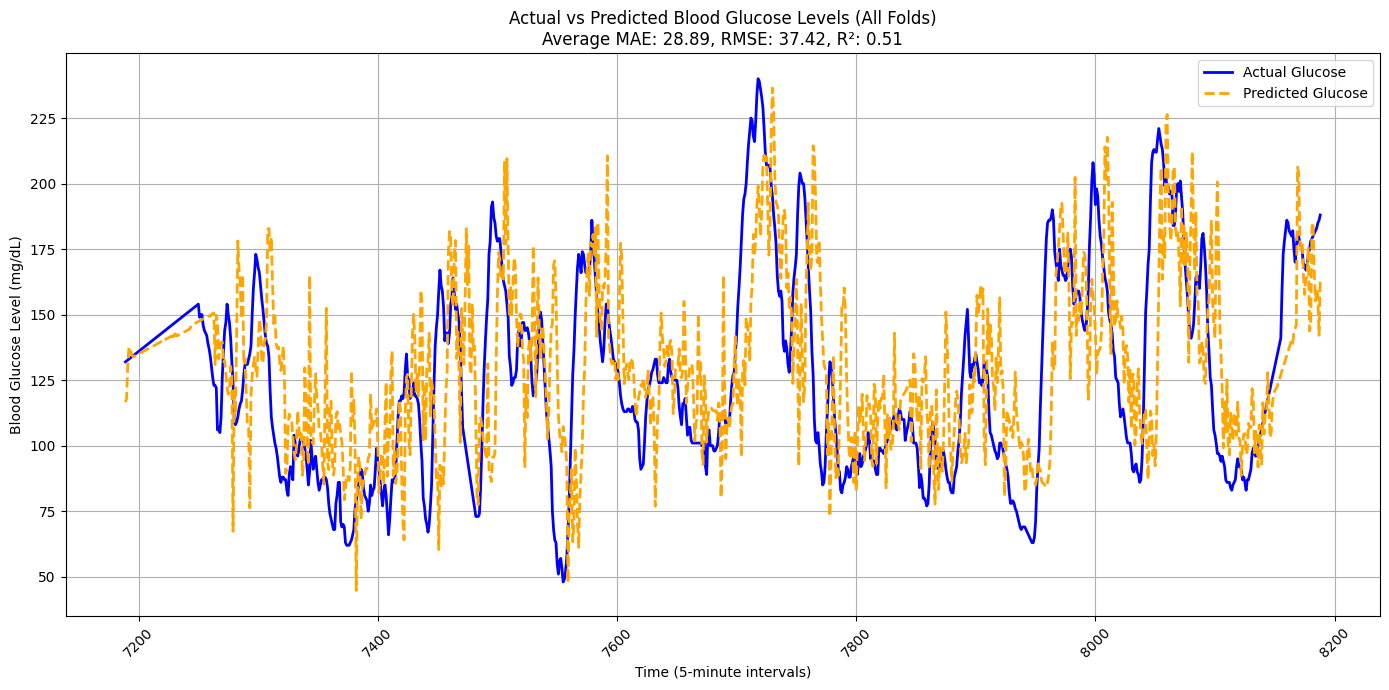

In [48]:
# Evaluating Model

# Calculate average metrics across all folds
average_mae = np.mean(mae_scores)
average_rmse = np.mean(rmse_scores)
average_r2 = np.mean(r2_scores)

# Print average performance across all folds
print(f'Average MAE: {average_mae}')
print(f'Average RMSE: {average_rmse}')
print(f'Average R²: {average_r2}')

# Create a DataFrame for the results across all folds
results = pd.DataFrame({
    'Timestamp': all_timestamps,
    'Actual Glucose': all_actuals,
    'Predicted Glucose': all_predictions
})

display(results)

# Sort the results by Timestamp
results = results.sort_values('Timestamp')

# Plotting the actual vs predicted glucose levels across all folds
# Note that data starts onlu at 2189 because of how we split the data test/train
plt.figure(figsize=(14, 7))
plt.plot(results['Timestamp'][5000:6000], results['Actual Glucose'][5000:6000], label='Actual Glucose', color='blue', linewidth=2)
plt.plot(results['Timestamp'][5000:6000], results['Predicted Glucose'][5000:6000], label='Predicted Glucose', color='orange', linestyle='--', linewidth=2)
plt.title(f'Actual vs Predicted Blood Glucose Levels (All Folds)\nAverage MAE: {average_mae:.2f}, RMSE: {average_rmse:.2f}, R²: {average_r2:.2f}')
plt.xlabel('Time (5-minute intervals)')
plt.ylabel('Blood Glucose Level (mg/dL)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()